# Import Modules

In [1]:
using HDF5, Plots, Statistics, LinearAlgebra
using MorporJ

# Import Learning Snapshots

In [2]:
###### INPUT ######

N = 1002
M = N

tol_icdf = 1e-6
tol_cdf = 1e-6

### Vectors of Parameters used for learning

β = [2,3,4,5,6]
μ = [1,2,3,6,12,25]
t = collect(3:2:51)

### Vectors of Parameters used for testing

βₜ = [2,3,4,5,6]        # possible values: [2,3,4,5,6]
μₜ = [1,2,3,6,12,25]    # possible values: [1,2,3,6,12,25,50,100]
tₜ = collect(3:2:51)    # possible values: [1,2,...,51]

paramnames = ("β", "μ", "t")
params = (1.0*β, 1.0*μ, 1.0*t)
paramsₜ = (1.0*βₜ, 1.0*μₜ, 1.0*tₜ)

###### END OF INPUT ######

# Tensor of snapshots and reshaping map
A = zeros(length(β), length(μ), length(t), N)
ci = CartesianIndices(size(A)[1:(end-1)])

Aₜ = zeros(length(βₜ), length(μₜ), length(tₜ), N)
ciₜ = CartesianIndices(size(Aₜ)[1:(end-1)])

fid = h5open("../snapshots/data_homogeneous_mu_exp.h5", "r")

for i in eachindex(β)
    for j in eachindex(μ)
            g = read(fid, "snap_mu_$(μ[j])")
            dset = g["snap_exp_$(β[i])"]
            for l in eachindex(t)
                A[i,j,l,1] = 0    # add zero at position -2ε
                A[i,j,l,2] = 1    # add 1 at position -ε
                A[i,j,l,3:end] .= dset[t[l],:]
            end
        
    end
end

for i in eachindex(βₜ)
    for j in eachindex(μₜ)
            g = read(fid, "snap_mu_$(μₜ[j])")
            dset = g["snap_exp_$(βₜ[i])"]
            for l in eachindex(tₜ)
                Aₜ[i,j,l,1] = 0    # add zero at position -2ε
                Aₜ[i,j,l,2] = 1    # add one at position -ε
                Aₜ[i,j,l,3:end] .= dset[tₜ[l],:]
            end
        
    end
end

# Snapshot matrix: N × nₜₚ
S = reshape(A,:,N)'
Sₜ = reshape(Aₜ,:,N)'

nₜₚ = size(S)[2]
Nₜₚ = size(Sₜ)[2]
close(fid)
i₀ = 1 
nₜₚ, Nₜₚ

(750, 750)

In [3]:
### EXAMPLE 2

#=

N = 1002
M = N

tol_icdf = 1e-12
tol_cdf = 1e-12

### Vectors of Parameters used for learning

α = [0,0.05,0.1,0.15,0.2,0.4,0.6] 
LP = [5,6,7,8,9]
t = collect(6:5:101)

### Vectors of Parameters used for testing

αₜ = [0,0.05,0.1,0.15,0.2,0.4,0.6] 
LPₜ = [5,6,7,8,9]
tₜ = collect(6:5:101)


# Tensor of snapshots and reshaping map
A = zeros(length(α), length(LP), length(t), N)
ci = CartesianIndices(size(A)[1:(end-1)])

Aₜ = zeros(length(αₜ), length(LPₜ), length(tₜ), N)
ciₜ = CartesianIndices(size(Aₜ)[1:(end-1)])

fid = h5open("../snapshots/data_heterogeneous_LPperm_jump.h5", "r")

for i in eachindex(α)
    for j in eachindex(LP)
        
            g = read(fid, "HPLP_snap_LPperm_$(LP[j])e-14")
            dset = g["jump_$(α[i]*1000)"]
            for l in eachindex(t)
                A[i,j,l,1] = 0    # add zero at position -ε
                A[i,j,l,2] = 1 
                A[i,j,l,3:end] .= dset[t[l],:]
            end
        
    end
end

for i in eachindex(αₜ)
    for j in eachindex(LPₜ)
            g = read(fid, "HPLP_snap_LPperm_$(LPₜ[j])e-14")
            dset = g["jump_$(αₜ[i]*1000)"]
            for l in eachindex(tₜ)
                Aₜ[i,j,l,1] = 0    # add zero at position -ε
                Aₜ[i,j,l,2] = 1
                Aₜ[i,j,l,3:end] .= dset[tₜ[l],:]
            end
        
    end
end


paramnames = ("α", "LP", "t")
params = (1.0*α, 1.0*LP, 1.0*t)
paramsₜ = (1.0*αₜ, 1.0*LPₜ, 1.0*tₜ)

# Snapshot matrix: N × nₜₚ
S = reshape(A,:,N)'
Sₜ = reshape(Aₜ,:,N)'

nₜₚ = size(S)[2]
Nₜₚ = size(Sₜ)[2]
close(fid)
nₜₚ, Nₜₚ

=#

# Compute ICDFs

In [3]:
xgrid = collect(range(0, 1, length = N)); pgrid = collect(range(0, 1, length = M))
Δx = xgrid[2] - xgrid[1]; Δp = pgrid[2] - pgrid[1]

# normalize
S₁, mass = MorporJ.get_S₁(S, Δx)
S₁ₜ, massₜ = MorporJ.get_S₁(Sₜ, Δx)

# icdfs
s = MorporJ.get_s(S₁, Δx, xgrid, pgrid)
sₜ = MorporJ.get_s(S₁ₜ, Δx, xgrid, pgrid);

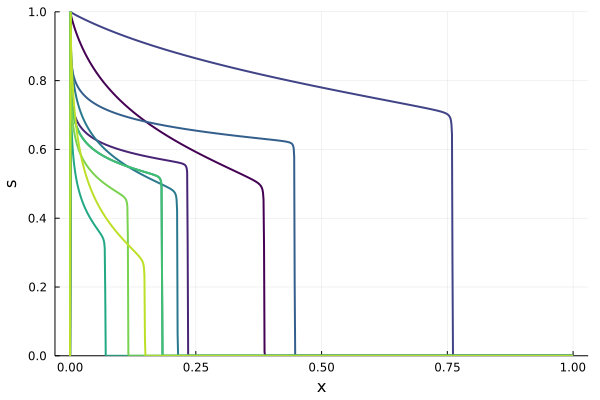

In [4]:
plot(xgrid, Sₜ[:, rand(Nₜₚ-length(μ)*length(β):Nₜₚ,10)],
    xlabel="x", ylabel="s", linewidth=2, legend=:none, ylim=(0,1), palette = palette(:viridis, 11)[1:10])

# Finding the atoms


In [5]:
### initial 2 atoms
a, basis_index = MorporJ.get_initial_atoms(s);
basis_index

2-element Vector{Int64}:
 721
  30

In [6]:
### greedy algorithm
Λ, ΔW, ΔW_max, ΔW_avg, a, basis_index = MorporJ.greedy_algo!(s, a, Δp, basis_index; 
                                                            rtol=-1e3, 
                                                            tol=1e-6, 
                                                            max_iter_greedy=9, 
                                                            max_iter_solver=Int(1e7));

------------------------------------- 
Iteration 1 
Maximum W2 error: 6.48e-03 
Average W2 error: 1.12e-03 
Atoms used: 721 30 
------------------------------------- 
Adding snapshot number: 736 


------------------------------------- 
Iteration 2 
Maximum W2 error: 2.78e-03 
Average W2 error: 6.14e-04 
Atoms used: 721 30 736 
------------------------------------- 
Adding snapshot number: 724 
------------------------------------- 


Iteration 3 
Maximum W2 error: 2.16e-03 
Average W2 error: 2.33e-04 
Atoms used: 721 30 736 724 
------------------------------------- 
Adding snapshot number: 746 
------------------------------------- 


Iteration 4 
Maximum W2 error: 1.95e-03 
Average W2 error: 1.55e-04 
Atoms used: 721 30 736 724 746 
------------------------------------- 
Adding snapshot number: 726 


------------------------------------- 
Iteration 5 
Maximum W2 error: 9.22e-04 
Average W2 error: 1.43e-04 
Atoms used: 721 30 736 724 746 726 
------------------------------------- 
Adding snapshot number: 722 


------------------------------------- 
Iteration 6 
Maximum W2 error: 5.94e-04 
Average W2 error: 1.32e-04 
Atoms used: 721 30 736 724 746 726 722 
------------------------------------- 
Adding snapshot number: 731 
------------------------------------- 


Iteration 7 
Maximum W2 error: 5.45e-04 
Average W2 error: 1.31e-04 
Atoms used: 721 30 736 724 746 726 722 731 
------------------------------------- 
Adding snapshot number: 725 
------------------------------------- 


Iteration 8 
Maximum W2 error: 3.54e-04 
Average W2 error: 1.17e-04 
Atoms used: 721 30 736 724 746 726 722 731 725 
------------------------------------- 
Adding snapshot number: 723 


------------------------------------- 
Iteration 9 
Maximum W2 error: 3.45e-04 
Average W2 error: 1.15e-04 
Atoms used: 721 30 736 724 746 726 722 731 725 723 
------------------------------------- 
Maximum iterations reached: 9 


In [7]:
print("Parameter values chosen by the greedy algorithm: \n")
print(paramnames)
print("\n")
a_params = zeros(length(a), length(paramnames))
k = 1
for a in basis_index
    (i,j,l) = Tuple(ci[a])
    a_params[k, :] = [ params[1][i], params[2][j], params[3][l] ]
    k+=1
    print(params[1][i], " ", params[2][j], " ", params[3][l])
    print("\n")
end

Parameter values chosen by the greedy algorithm: 
(

"β", "μ", "t")
2.0 1.0 51.0
6.0 25.0 3.0
2.0 6.0 51.0
5.0 1.0 51.0
2.0 25.0 51.0
2.0 2.0 51.0
3.0 1.0 51.0
2.0 3.0 51.0
6.0 1.0 51.0
4.0 1.0 51.0


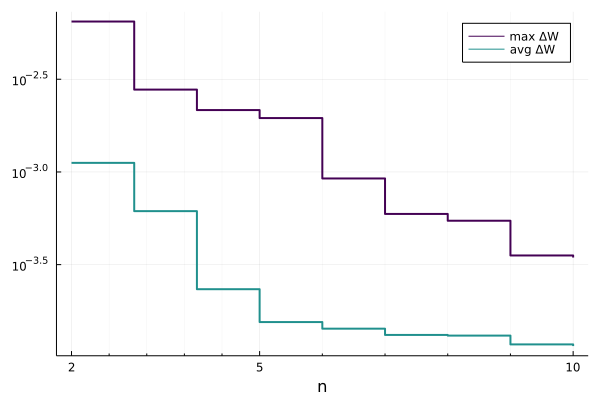

In [8]:
### Greedy W₂ error
plot(2:length(ΔW_max)+1, [ΔW_max ΔW_avg],
    yaxis = :log, xticks=vcat(2,collect(5:5:length(ΔW_max)+1)), minorgrid=true, 
    linetype=:steppost, linewidth=2, xlabel = "n", label = ["max ΔW" "avg ΔW"], palette = palette(:viridis, 3)[1:2])

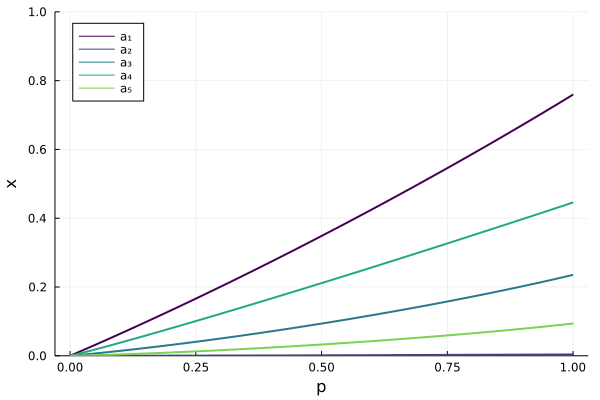

In [9]:
### atoms 1-5
plot(xgrid, s[basis_index[1:5]], xlabel="p", ylabel="x", linewidth=2, ylim=(0,1), 
    label=[ "a₁" "a₂" "a₃" "a₄" "a₅"], palette = palette(:viridis, 6)[1:5],
    legend = :topleft)

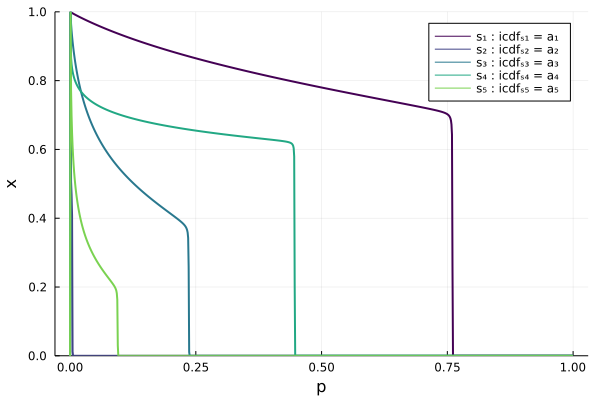

In [10]:
### Saturations of atoms 1-5
plot(xgrid, S[:,basis_index[1:5]], xlabel="p", ylabel="x", linewidth=2, ylim=(0,1), 
    label=[ "s₁ : icdfₛ₁ = a₁" "s₂ : icdfₛ₂ = a₂" "s₃ : icdfₛ₃ = a₃" "s₄ : icdfₛ₄ = a₄" "s₅ : icdfₛ₅ = a₅"],
    legend = :topright, palette = palette(:viridis, 6)[1:5])

# Interpolations

In [11]:
n_ = 3
itp, mass_itp = MorporJ.get_interpolates(params, Λ[n_-1], mass);

In [12]:
### Example 1
β_axis = collect(range(βₜ[1], βₜ[end], length=50))
μ_axis = collect(range(μₜ[1], μₜ[end], length=50))

### Example 2
#α_axis = collect(range(αₜ[1], αₜ[end], length=50))
#LP_axis = collect(range(LPₜ[1], LPₜ[end], length=50))

t_axis = collect(range(tₜ[1], tₜ[end], length=50));

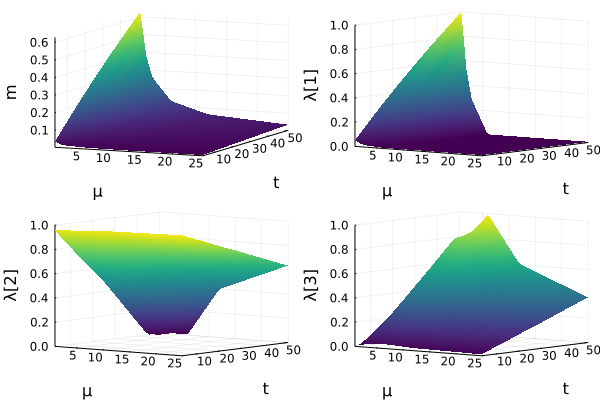

In [13]:
### Example 1
plts = Tuple(surface(μ_axis, t_axis, (x,y) -> itp[i](βₜ[1], x, y)', zlim=[0, 1], zlab="λ[$i]", xlab="μ", ylab="t", camera=(40,20), legend = :none, c = :viridis) for i in 1:length(Λ[n_-1][1]) );
massplt = surface(μ_axis, t_axis, (x,y) -> mass_itp(βₜ[1], x, y)', zlab="m", xlab="μ", ylab="t", camera=(30,30), legend = :none, c = :viridis);

### Example 2
#plts = Tuple(surface(α_axis, t_axis, (x,y) -> itp[i](x, LPₜ[1], y)', zlim=[0, 1], zlab="λ[$i]", xlab="γ", ylab="t", camera=(40,20), legend = :none, c = :viridis) for i in 1:length(Λ[n_-1][1]) );
#massplt = surface(α_axis, t_axis, (x,y) -> mass_itp(x, LPₜ[1], y)', zlab="m", xlab="γ", ylab="t", camera=(30,30), legend = :none, c = :viridis);

plot(massplt, plts...)

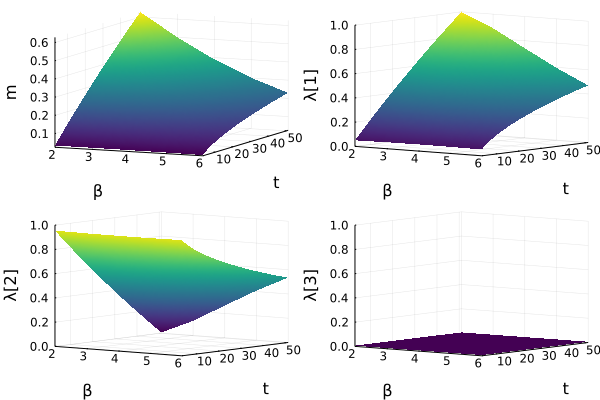

In [14]:
### Example 1
plts = Tuple(surface(β_axis, t_axis, (x,y) -> itp[i](x, μₜ[1] , y)', zlim=[0, 1], zlab="λ[$i]", xlab="β", ylab="t", camera=(40,20), legend = :none, c = :viridis) for i in 1:length(Λ[n_-1][1]) );
massplt = surface(β_axis, t_axis, (x,y) -> mass_itp(x, μₜ[1] , y)', zlab="m", xlab="β", ylab="t", camera=(30,30), legend = :none, c = :viridis);

### Example 2
#plts = Tuple(surface(LP_axis, t_axis, (x,y) -> itp[i](αₜ[3], x, y)', zlim=[0, 1], zlab="λ[$i]", xlab="LP", ylab="t", camera=(40,20), legend = :none, c = :viridis) for i in 1:length(Λ[n_-1][1]) );
#massplt = surface(LP_axis, t_axis, (x,y) -> mass_itp(αₜ[3], x, y)', zlab="m", xlab="LP", ylab="t", camera=(30,30), legend = :none, c = :viridis);

plot(massplt, plts...)

# Testing

In [15]:
n_ = 10
Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[n_-1], mass, a[1:n_], params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);

In [16]:
ΔL1 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 1) / norm( Sₜ[:,k], 1) for k in i₀:Nₜₚ ]
ΔL1ₑ = [ norm( Sₜ[:,k] - Sₑ[:,k], 1) / norm( Sₜ[:,k], 1) for k in i₀:Nₜₚ ];
print("avg. L1 error: ", sum(ΔL1)/Nₜₚ, ", lower bound by numerical inversion/differentiation: ", sum(ΔL1ₑ)/Nₜₚ)

avg. L1 error: 0.02051791710313123, lower bound by numerical inversion/differentiation: 0.0004328444003482065

# Generate Traces

In [17]:
### POD modes
U_ = svd(Sₜ).U;

In [18]:
### L1 error (gBar) for k = 1,...,n

nᵢₜ = length(Λ)

avgΔL1_tr = zeros(nᵢₜ)
maxΔL1_tr = zeros(nᵢₜ)
sdΔL1_tr = zeros(nᵢₜ)
medΔL1_tr = zeros(nᵢₜ)

for k in 1:nᵢₜ
    Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[k], mass, a[1:(k+1)], params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);

    ΔL1 = [ norm( Sₜ[:,k] - Sᵣ[:,k], 1) / norm( Sₜ[:,k], 1) for k in i₀:Nₜₚ ]

    avgΔL1_tr[k] = mean( ΔL1 )
    maxΔL1_tr[k] = maximum( ΔL1 )
    medΔL1_tr[k] = median( ΔL1 )
    sdΔL1_tr[k] = std( ΔL1; corrected=false )

end

### L1 error (POD) for k = 1,...,n

nₚₒ = 25

avgΔL1_tr_pod = zeros(nₚₒ-1)
maxΔL1_tr_pod = zeros(nₚₒ-1)
sdΔL1_tr_pod = zeros(nₚₒ-1)
medΔL1_tr_pod = zeros(nₚₒ-1)

for k in 2:nₚₒ
    Ψ = U_[:,1:k]
    Π = Ψ * Ψ'
    ΔL1_pod = [ norm( Sₜ[:,i] - Π * Sₜ[:,i], 1) / norm( Sₜ[:,i], 1) for i in i₀:Nₜₚ ]

    avgΔL1_tr_pod[k-1] = mean( ΔL1_pod )
    maxΔL1_tr_pod[k-1] = maximum( ΔL1_pod )
    medΔL1_tr_pod[k-1] = median( ΔL1_pod )
    sdΔL1_tr_pod[k-1] = std( ΔL1_pod; corrected=false)
end
    

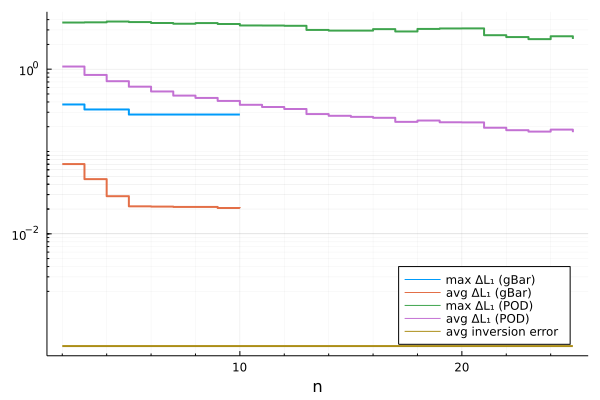

In [19]:
plot(2:nᵢₜ+1, maxΔL1_tr, label="max ΔL₁ (gBar)", xlab = "n", xticks=10:10:nₚₒ, 
        yaxis=:log, minorgrid=true, linetype=:steppost, linewidth=2, legend=:bottomright)
plot!(2:nᵢₜ+1, avgΔL1_tr, label="avg ΔL₁ (gBar)", linetype=:steppost, linewidth=2)
plot!(2:nₚₒ, maxΔL1_tr_pod, label="max ΔL₁ (POD)", linetype=:steppost, linewidth=2)
plot!(2:nₚₒ, avgΔL1_tr_pod, label="avg ΔL₁ (POD)", linetype=:steppost, linewidth=2)
plot!(2:nₚₒ, ones(nₚₒ-1) .* mean(ΔL1ₑ), label="avg inversion error", linetype=:steppost, linewidth=2)
    

In [20]:
### Conditioning number of A^T A

cond_M = zeros(nᵢₜ)
for k in 2:nᵢₜ+1
    _M = zeros(k,k)
    for i in 1:k
        for j in i:k
            _M[i,j] = dot(a[i], a[j])
            _M[j,i] = _M[i,j]
        end
    end
    cond_M[k-1] = LinearAlgebra.cond(_M)
end

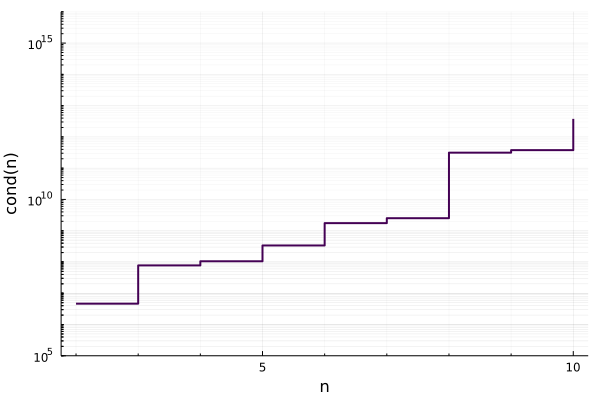

In [21]:
plot(2:nᵢₜ+1, cond_M, xlab="n", ylab="cond(n)", ylim = (1e5,1e16), label=false,
    yaxis=:log, minorgrid=true, linetype=:steppost, legend = :topleft, linewidth=2, xticks=5:5:nᵢₜ+1, palette = palette(:viridis, 3)[1:2] )

# Reconstruction & comparison with POD

In [22]:
nₚₒ = 4*16
nₐ = 4
Ψ = U_[:,1:nₚₒ]
Π = Ψ * Ψ'

Sᵣ, mᵣ, Sₑ = MorporJ.test_interpolations(Λ[nₐ-1], mass, a[1:nₐ], params, massₜ, paramsₜ, Sₜ, sₜ, ciₜ, Δx, xgrid, pgrid, tol_icdf);

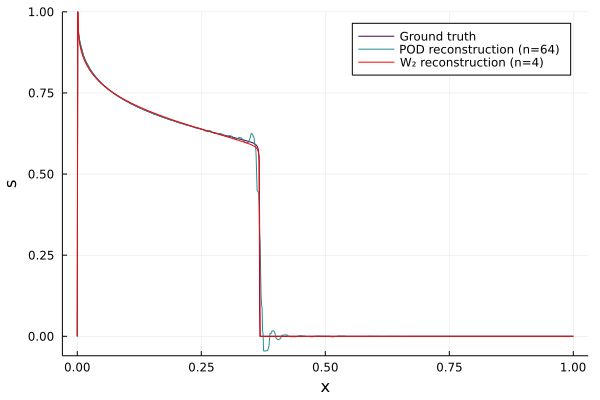

In [23]:
iₑₓ = 547
# 684 for exmaple 2
# rand(1:Nₜₚ) for other examples

plot(xgrid, Sₜ[:,iₑₓ], label="Ground truth", xlabel="x", ylabel="s", ylim=(-0.06,1), linewidth=1, palette = palette(:viridis, 3)[1:2])
plot!(xgrid, Π * Sₜ[:,iₑₓ], label="POD reconstruction (n=$nₚₒ)", linewidth=1)
plot!(xgrid, Sᵣ[:,iₑₓ], label="W₂ reconstruction (n=$nₐ)", linewidth=1, color = :red)

In [25]:
function area(v1, v2, v3)
    A = hcat(v1,v2,v3)
    A = vcat(ones(1,3),A)
    return 0.5*abs(det(A))
end

function b_weights_n(x,v)
    n = length(v)
    A = zeros(n)
    C = zeros(n)
    w = zeros(n)
    ϕ = zeros(n)

    for i in 1:n
        if i == 1
            C[i] = area(v[n],v[1],v[2])
            A[i] = area(x,v[1],v[2])
        elseif i == n
            C[i] = area(v[n-1],v[n],v[1])
            A[i] = area(x,v[n],v[1])
        else
            C[i] = area(v[i-1],v[i],v[i+1])
            A[i] = area(x,v[i],v[i+1])
        end
    end

    for i in 1:n
        if i == 1
            w[i] = C[i] / (A[i] * A[n])
        else
            w[i] = C[i] / (A[i] * A[i-1])
        end
    end

    ϕ .= w ./ sum(w)

    return ϕ
end


function w_err(λ,a,tar)
    bar = zeros(M)
    for i in 1:length(λ)
        bar .+= λ[i] .* a[i]
    end

    return sqrt(Δp) * norm(bar - tar, 2)
end

w_err (generic function with 1 method)

# Energy landscape

In [26]:
### 3 atoms
_x = collect(0:0.01:1)
_y = collect(0:0.01:1)
v = ( [0,0], [1,0], [0.5, 1.0] )

W_err = zeros(length(_x), length(_y))

for i in eachindex(_x)
    for j in eachindex(_y)
        if _y[j] > _x[i] * 2
            W_err[i,j] = NaN
        elseif _y[j] > 2 - _x[i] * 2
            W_err[i,j] = NaN
        else
            λ = b_weights_n( [ _x[i], _y[j] ], v )
            W_err[i,j] = w_err(λ, a, sₜ[iₑₓ])
        end
    end
end

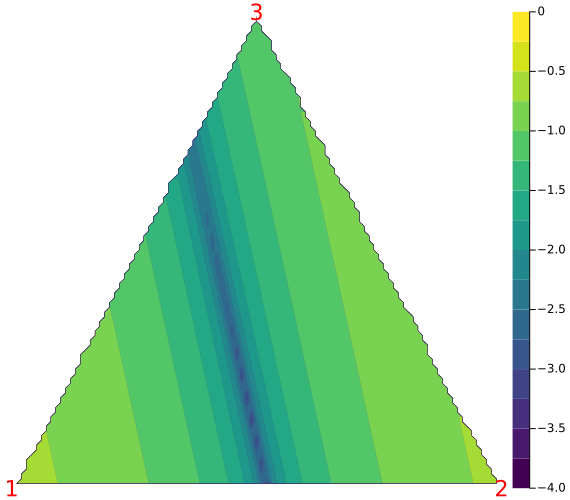

In [27]:
plt = contourf(_x, _y, log10.(W_err)', clims = (-4,0), linewidth = 0, color = :viridis, axis = false, grid = false, ticks = false)
plot!(size=(570,500))
for i in 1:length(v)
    annotate!(v[i]...,text("$i", :red, 15))
end
plt

In [28]:
v = ( [0,0], [1,0], [1,1], [0,1] )

W_err = zeros(length(_x), length(_y))

for i in eachindex(_x)
    for j in eachindex(_y)
            λ = b_weights_n( [ _x[i], _y[j] ], v )
            W_err[i,j] = w_err(λ, a, sₜ[iₑₓ])
    end
end

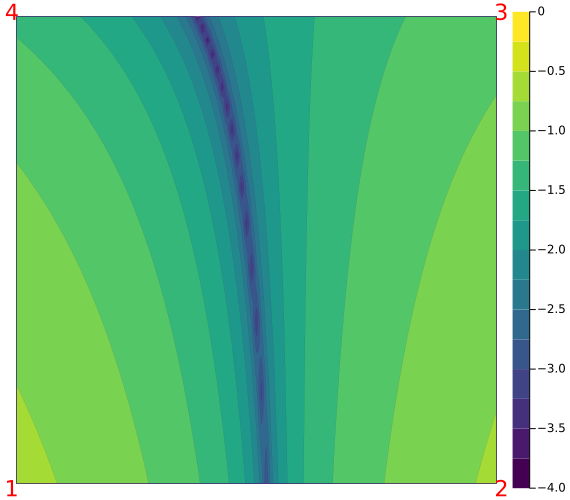

In [29]:
plt = contourf(_x, _y, log10.(W_err)', linewidth = 0, color = :viridis, axis = false, clims = (-4,0), grid = false, ticks = false)
plot!(size=(570,500))
for i in 1:length(v)
    annotate!(v[i]...,text("$i", :red, 15))
end
plt

In [30]:
cst = 0.3
v = ( [cst,0], [1-cst,0], [1,cst], [1,1-cst], [1-cst,1], [cst,1], [0,1-cst], [0,cst] )

W_err = zeros(length(_x), length(_y))

for i in eachindex(_x)
    for j in eachindex(_y)
            λ = b_weights_n( [ _x[i], _y[j] ], v )
            if _y[j] < cst - _x[i]
                W_err[i,j] = NaN
            elseif _y[j] > 1 - cst + _x[i]
                W_err[i,j] = NaN
            elseif _y[j] > 1 + 1 - cst - _x[i]
                W_err[i,j] = NaN
            elseif _y[j] < -1 + cst + _x[i]
                W_err[i,j] = NaN
            else
                W_err[i,j] = w_err(λ, a, sₜ[iₑₓ])
            end
    end
end

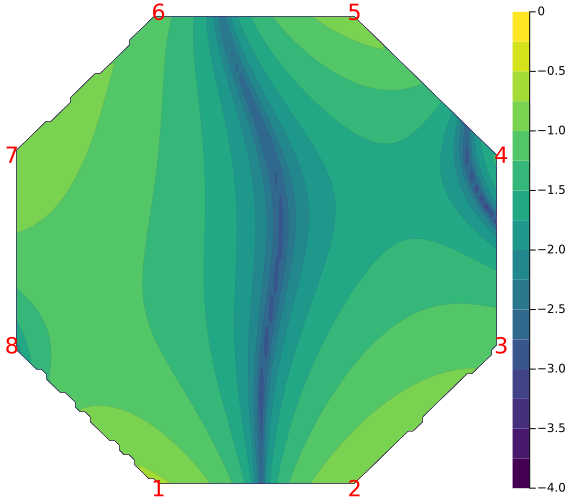

In [31]:
plt = contourf(_x, _y, log10.(W_err)', linewidth = 0, color = :viridis, axis = false, grid = false, clims = (-4,0), ticks = false)
plot!(size=(570,500))
for i in 1:length(v)
    annotate!(v[i]...,text("$i", :red, 15))
end
plt

# Simplex Volumes

In [32]:
vols = []
delta_vols = []
for __n in 2:length(a)
    D = zeros(__n,__n)
    for i in 1:__n
        for j in 1:__n
            D[i,j] = norm(a[i]-a[j],2)
        end
    end
    D = hcat(D, ones(__n))
    D = vcat(D, ones(__n+1)')
    D[end,end] = 0
    vol = sqrt(det(D) * (-1)^(__n) / ( 2^(__n-1) ) )
    push!(vols, vol)
    if __n > 2
        push!(delta_vols, vols[end]/vols[end-1] - 1)
    end
end

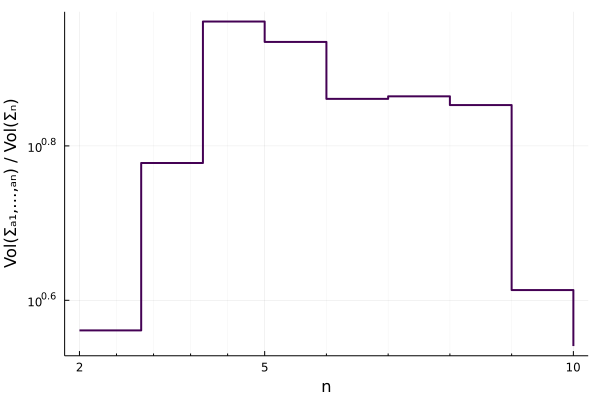

In [33]:
plot(2:length(vols)+1, vols,
    yaxis = :log, xticks=vcat(2,collect(5:5:length(vols)+1)), minorgrid=true, 
    linetype=:steppost, linewidth=2, xlabel = "n", ylabel = "Vol(Σₐ₁,…,ₐₙ) / Vol(Σₙ)", label=false,
    palette = palette(:viridis, 3)[1:2])